In [118]:
import datetime
import json
import boto3
import io
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
#import seaborn as sns
plt.style.use('ggplot')

In [119]:
pickle_file = '../btc-autotrader/lib/data/log/2019-03-27T12:13:41.971340.pickle'

In [120]:
df = pd.read_pickle(pickle_file)

In [121]:
df.head()

,datetime,cash,cash_orig,btc_in_possession,btc_current_price,position,rate_of_change,total_value,acceleration,bid_high,ask_low,mid_price,bought_price,sold_price,target_price,size
0,2019-03-27 12:13:47.609948,45704.0,0,0.005488,438701.0,0,None,0,None,438701.0,438801.0,438751.0,0,0,0,0
0,2019-03-27 12:13:52.630522,45704.0,0,0.005488,438701.0,0,-1.09001,0,None,438701.0,438801.0,438751.0,0,0,0,0
0,2019-03-27 12:13:57.653076,45704.0,0,0.005488,438701.0,0,-1.09001,0,0,438701.0,438801.0,438751.0,0,0,0,0
0,2019-03-27 12:14:02.674808,45704.0,0,0.005488,438701.0,0,-1.09001,0,0,438700.0,438701.0,438700.0,0,0,0,0
0,2019-03-27 12:14:07.699186,45704.0,0,0.005488,438701.0,0,-0.999996,0,0.0179111,438700.0,438801.0,438750.0,0,0,0,0


In [122]:
df['spread'] = df.ask_low - df.bid_high

In [123]:
df['spread_pct_change'] = df.spread.pct_change()

In [124]:
df.loc[df.rate_of_change >= 0, 'rate_of_change_positive'] = 1
df.loc[df.rate_of_change < 0, 'rate_of_change_positive'] = -1
df.loc[df.rate_of_change >= 5, 'rate_of_change_positive'] = 2
df.loc[df.rate_of_change < -5, 'rate_of_change_positive'] = -2

In [125]:
df['btc_current_price_normalized'] = (df.btc_current_price - df.btc_current_price.mean()) / df.btc_current_price.std()


In [126]:
df['returns'] = np.log(df['btc_current_price']/df['btc_current_price'].shift(1))

In [127]:
df['strategy'] = df['rate_of_change_positive'].shift(1) * df['returns']

In [128]:
df.tail()

,datetime,cash,cash_orig,btc_in_possession,btc_current_price,position,rate_of_change,total_value,acceleration,bid_high,...,bought_price,sold_price,target_price,size,spread,spread_pct_change,rate_of_change_positive,btc_current_price_normalized,returns,strategy
0,2019-03-27 12:27:11.138195,45704.0,0,0.005488,438799.0,0,-0.0303693,0,0,438599.0,...,0,0,0,0,200.0,-0.004975,-1.0,1.022281,0.000000,-0.000000
0,2019-03-27 12:27:16.164492,45704.0,0,0.005488,438799.0,0,-0.0303693,0,0,438599.0,...,0,0,0,0,200.0,0.000000,-1.0,1.022281,0.000000,-0.000000
0,2019-03-27 12:27:21.194937,41317.0,0,0.015477,438799.0,1,0.0278032,0,0.0115605,438599.0,...,0,0,0,0,201.0,0.005000,1.0,1.022281,0.000000,-0.000000
0,2019-03-27 12:27:26.218235,36929.0,0,0.025465,438800.0,1,0.0845708,0,0.0112905,438599.0,...,0,0,0,0,201.0,0.000000,1.0,1.026194,0.000002,0.000002
0,2019-03-27 12:27:31.239893,32542.0,0,0.035454,438620.0,1,0.131132,0,0.00927059,438599.0,...,0,0,0,0,21.0,-0.895522,1.0,0.321746,-0.000410,-0.000410


In [129]:
np.exp(df[['returns', 'strategy']].sum())

returns     0.999815
strategy    0.999369
dtype: float64

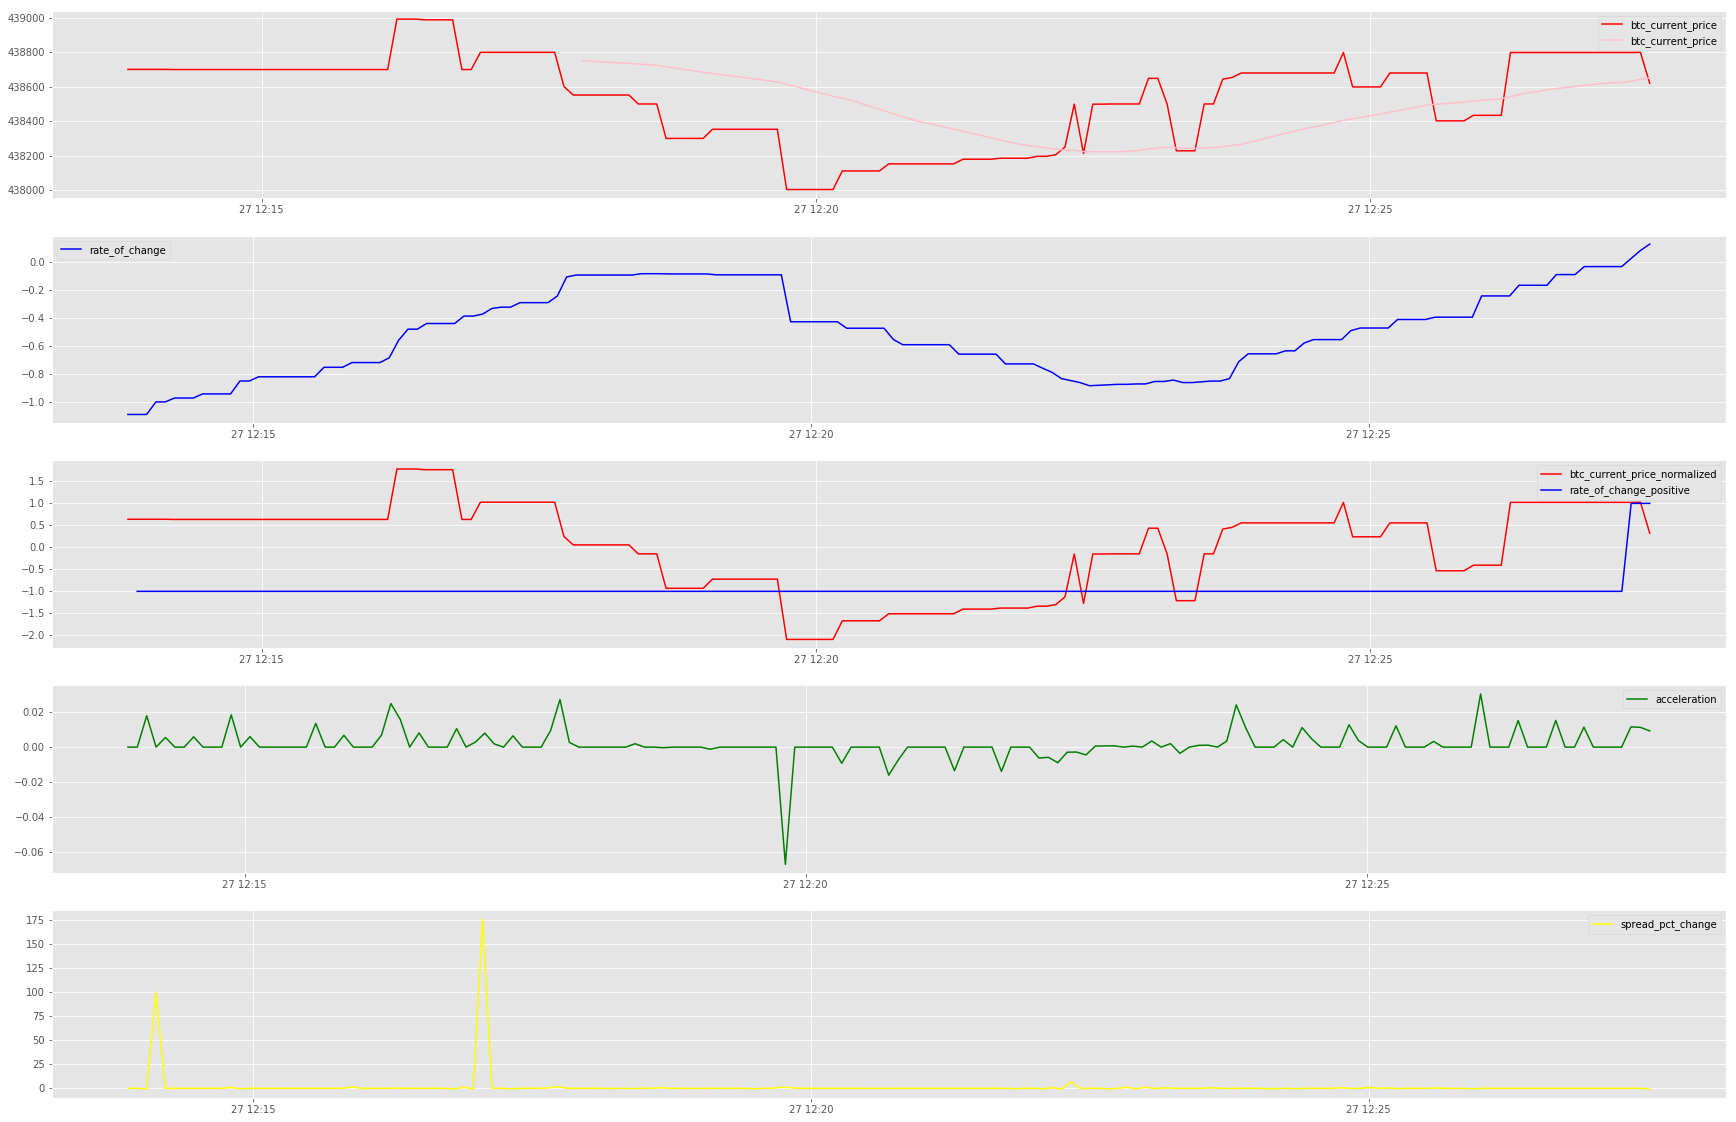

In [130]:
num = 5
fig, axes = plt.subplots(nrows=num, ncols=1, figsize=(30, 20), sharex=True)
plt.subplot(num,1,1)
plt.plot(df.datetime, df.btc_current_price, color='r')
plt.plot(df.datetime, df.btc_current_price.rolling(50).mean(), color='pink')
plt.legend()
#ax1.plot(df.datetime, df.ask_low, color='cyan', linestyle='--')
#ax1.plot(df.datetime, df.bid_high, color='magenta', linestyle='--')
#ax2.plot(df.datetime, df.spread, color='gray')
#ax1.scatter(df.datetime, df.bid_price, color='black')
plt.subplot(num,1,2)
plt.plot(df.datetime, df.rate_of_change, color='b')
plt.legend()
plt.subplot(num,1,3)
plt.plot(df.datetime, df.btc_current_price_normalized, color='r')
plt.plot(df.datetime, df.rate_of_change_positive, color='b')
plt.legend()
plt.subplot(num,1,4)
plt.plot(df.datetime, df.acceleration, color='g')
#plt.yscale('log')
plt.legend()
plt.subplot(num,1,5)
plt.plot(df.datetime, df.spread_pct_change, color='yellow')
plt.legend()
#plt.plot(df.datetime, df.spread_pct_change())
plt.show()

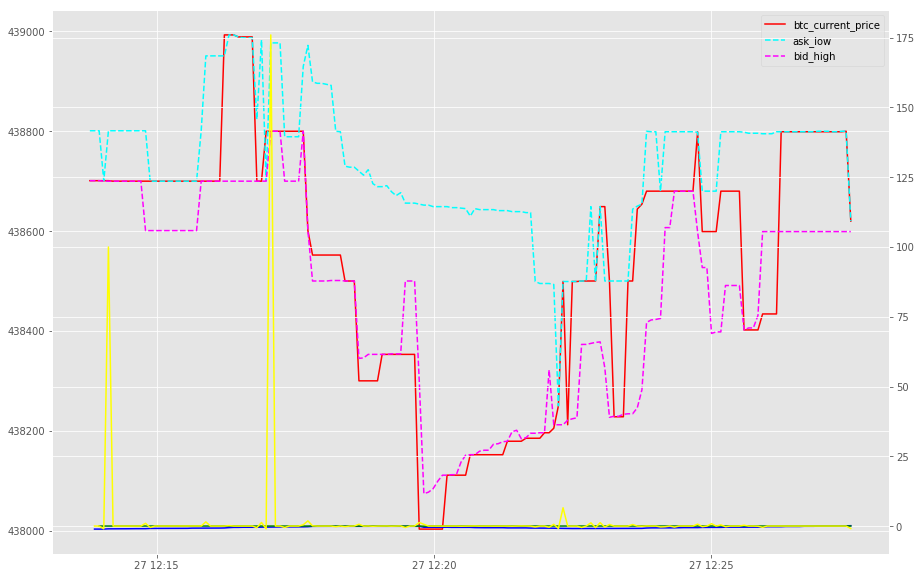

In [131]:
fig, ax1 = plt.subplots(figsize=(15,10))
ax2 = ax1.twinx()
ax1.plot(df.datetime, df.btc_current_price, color='r')
ax1.plot(df.datetime, df.ask_low, color='cyan', linestyle='--')
ax1.plot(df.datetime, df.bid_high, color='magenta', linestyle='--')
ax1.legend()
#ax2.plot(df.datetime, df.spread, color='gray')
#ax1.scatter(df.datetime, df.bid_price, color='black')
ax2.plot(df.datetime, df.rate_of_change, color='b')
ax2.plot(df.datetime, df.acceleration, color='g')
ax2.plot(df.datetime, df.spread_pct_change, color='yellow')
#ax2.legend()
plt.show()

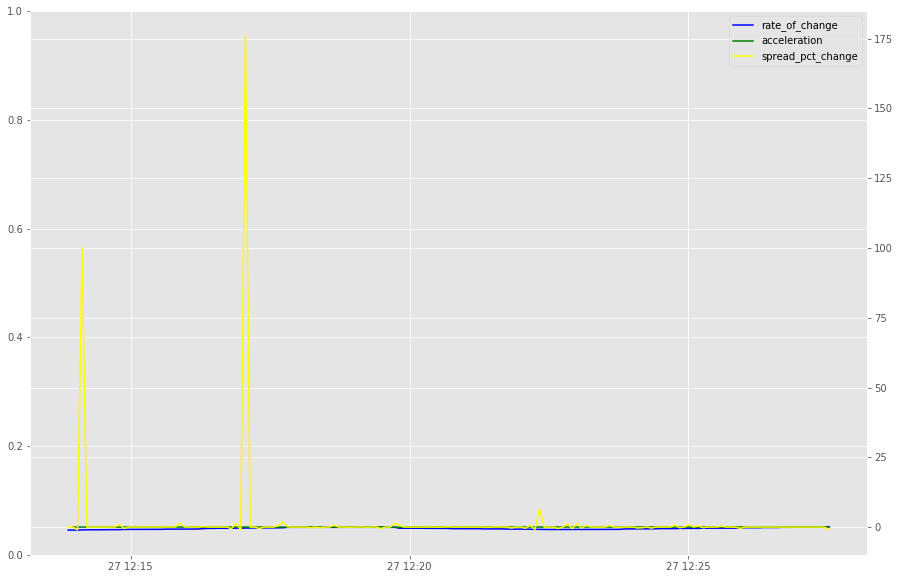

In [132]:
fig, ax1 = plt.subplots(figsize=(15,10))
ax2 = ax1.twinx()
#ax1.plot(df.datetime, df.btc_current_price, color='r')
#ax2.plot(df.datetime, df.spread, color='gray')
#ax1.scatter(df.datetime, df.bid_price, color='black')
ax2.plot(df.datetime, df.rate_of_change, color='b')
ax2.plot(df.datetime, df.acceleration, color='g')
ax2.plot(df.datetime, df.spread_pct_change, color='yellow')
ax2.legend()
plt.show()

In [133]:
df.total_value.iloc[-1] - df.total_value.iloc[0]

0

No handles with labels found to put in legend.


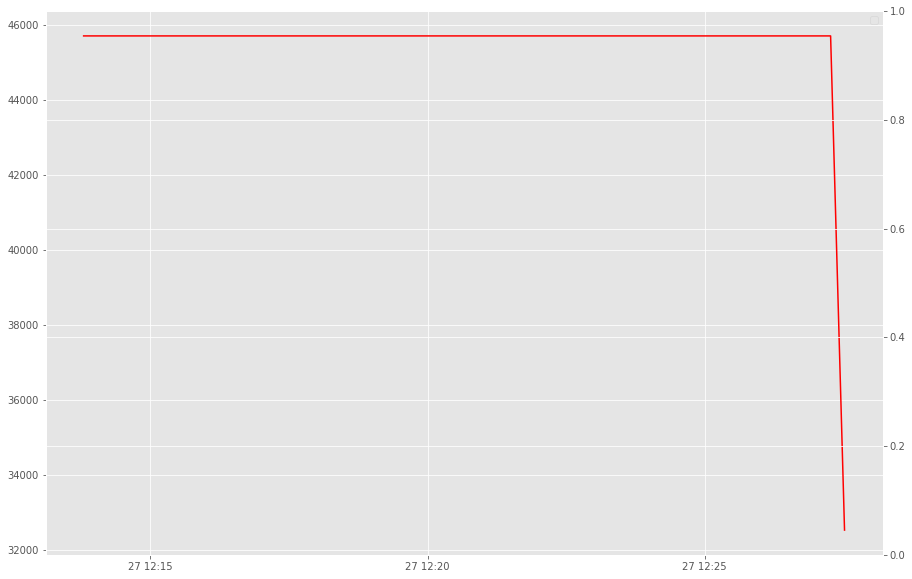

In [134]:
fig, ax1 = plt.subplots(figsize=(15,10))
ax2 = ax1.twinx()
ax1.plot(df.datetime, df.cash, color='r')
#ax2.plot(df.datetime, df.rate_of_change, color='b')
#ax2.plot(df.datetime, df.acceleration, color='g')
ax2.legend()
plt.show()